# MLNS data challenge

Guillaume Levy, Clement Wang, Adberrahim Namouh, Gaspard Berthelier

## Imports

In [1]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/MLNS/data_challenge

Mounted at /content/drive
/content/drive/My Drive/MLNS/data_challenge


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
from functools import partial
from tqdm.notebook import tqdm
import itertools
from time import perf_counter

## Load Data

In [4]:
# Load the node information with embeddings
node_info = pd.read_csv("data/node_information.csv", header=None)
node_info.columns = ["node_id"] + [f"embedding_{i}" for i in range(1, 933)]

# Load training and testing sets
train_data = pd.read_csv(
    "data/train_split.csv",
    header=0,
    names=["source_node", "target_node", "label"],
)
val_data = pd.read_csv(
    "data/val_split.csv",
    header=0,
    names=["source_node", "target_node", "label"],
)
test_data = pd.read_csv(
    "data/test.txt", header=None, sep=" ", names=["source_node", "target_node"]
)

# Shuffle
train_data = train_data.sample(frac=1)
val_data = val_data.sample(frac=1)

print("Train shape : ", train_data.shape)
print("Val shape: ", val_data.shape)
print("Test shape : ", test_data.shape)
print("Node info shape : ", node_info.shape)

Train shape :  (8398, 3)
Val shape:  (2098, 3)
Test shape :  (3498, 2)
Node info shape :  (3597, 933)


In [5]:
# Create train graph and add node attributes
train_graph = train_data[train_data.label == 1]
G: nx.Graph = nx.from_edgelist(train_graph[["source_node", "target_node"]].values)
for i in tqdm(range(1, 933)):
    nx.set_node_attributes(
        G, node_info.set_index("node_id")[f"embedding_{i}"].to_dict(), f"embedding_{i}"
    )
assert nx.is_connected(G)

  0%|          | 0/932 [00:00<?, ?it/s]

In [6]:
print(f"Graph shape : {len(G.nodes())} nodes , {len(G.edges())} edges")

Graph shape : 3597 nodes , 4199 edges


## Data Analysis

In [7]:
train_nodes = set(train_data.source_node).union(set(train_data.target_node))
val_nodes = set(val_data.source_node).union(set(val_data.target_node))
test_nodes = set(test_data.source_node).union(set(test_data.target_node))
print("Unique train & val nodes : ", len(train_nodes.union(val_nodes) - test_nodes))
print("Unique test nodes : ", len(test_nodes - train_nodes.union(val_nodes)))

Unique train & val nodes :  741
Unique test nodes :  0


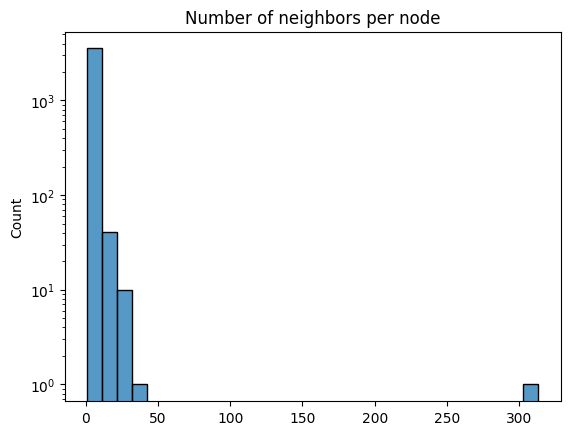

In [8]:
num_neighbors = [len(list(G.neighbors(node))) for node in G.nodes]
sns.histplot(num_neighbors,bins=30)
plt.yscale("log");
plt.title("Number of neighbors per node");

In [9]:
print("Is the total graph connected ? ",nx.is_connected(G))

Is the total graph connected ?  True


It's the famous "theorem" that says we are all connected to any human being via maximum 6 relations

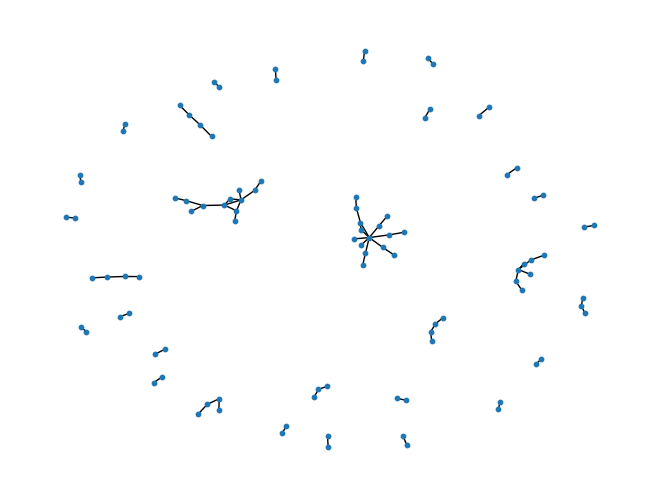

In [10]:
nx.draw(G.subgraph(list(G.nodes())[0:100]),node_size=10)

We noticed the data contains self loops which is anoying for the computation of the features. Since it is always the case where it is equal to 1, we will remove them from the graph for the training.

In [11]:
print("Number of self loops : ",len(np.where(train_data["source_node"] == train_data["target_node"])[0]))

Number of self loops :  18


Text(0.5, 1.0, 'Number of keywords per node')

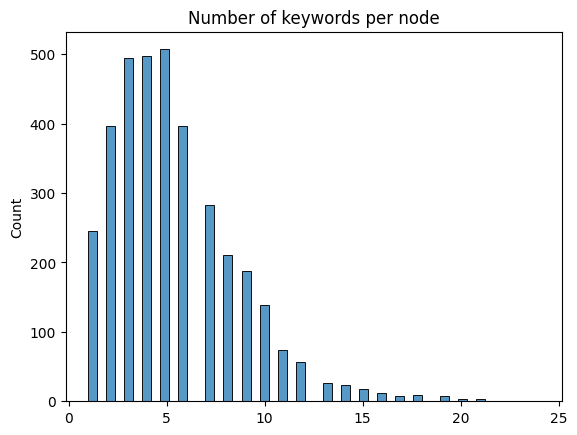

In [12]:
num_keywords = node_info.drop(columns=["node_id"]).sum(axis=1).astype(int)
sns.histplot(num_keywords,bins=50)
plt.title("Number of keywords per node")

We don't have any information as to what the keywords represent, so we cannot do any semantic analysis (NLP).

## Features

In [7]:
train_data.head()

,source_node,target_node,label
3195,2708,3215,0
2184,348,7416,0
3139,7283,7309,1
7467,130,3469,1
5648,3657,4741,1


In [8]:
node_info.head()

,node_id,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_923,embedding_924,embedding_925,embedding_926,embedding_927,embedding_928,embedding_929,embedding_930,embedding_931,embedding_932
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Node distances

def add_embeddings(df, embeddings):
  """returns dataframe with embeddings of both source and target node"""
  df = df.merge(embeddings, how="left", left_on="source_node", right_on="node_id")
  df = df.merge(
      embeddings,
      how="left",
      left_on="target_node",
      right_on="node_id",
      suffixes=("_source", "_target"),
  )
  df = df.drop(columns=["node_id_source","node_id_target"])
  return df


def compute_similarity(df_, embeddings):
    """returns cosine similarity and euclidean distance between node embeddings"""
    df = df_.copy()

    # Merge the embeddings dataframe to get the embeddings for both source and target nodes
    df = add_embeddings(df,embeddings)
    source_embeddings = df[[f"embedding_{i}_source" for i in range(1, 933)]].values
    target_embeddings = df[[f"embedding_{i}_target" for i in range(1, 933)]].values

    #Cosine similiarity
    cosine_sim = [cosine_similarity([s], [t])[0][0] for s, t in zip(source_embeddings, target_embeddings)]

    #Euclidean dist
    euclidean_dist = [np.linalg.norm(s - t) for s, t in zip(source_embeddings, target_embeddings)]

    #Num common words
    nb_common_words = []
    nb_total_words = []
    for s, t in zip(source_embeddings, target_embeddings):
        set_words_source = set(np.where(s > 0)[0])
        set_words_target = set(np.where(t > 0)[0])
        nb_common_words.append(len(set_words_source.intersection(set_words_target)))
        nb_total_words.append(len(set_words_source.union(set_words_target)))

    # Add the calculated features to the dataframe
    df["cosine_similarity"] = cosine_sim
    df["euclidean_distance"] = euclidean_dist
    df["nb_common_words"] = nb_common_words
    df["jaccard_similarity"] = np.array(nb_common_words)/np.array(nb_total_words)
    return df


t1 = perf_counter()
train_features = compute_similarity(train_data, node_info) #utilisés après
val_features = compute_similarity(val_data, node_info)
test_features = compute_similarity(test_data, node_info)
t2 = perf_counter()
print(f"Similiarity computed in {round((t2-t1)/60,4)} min")
print("Train shape : ",train_features.shape)
print("Val shape : ",val_features.shape)
print("Test shape : ",test_features.shape)

Similiarity computed in 0.1563 min
Train shape :  (8398, 1871)
Val shape :  (2098, 1871)
Test shape :  (3498, 1870)


In [10]:
# Node correspondance

def get_embbedding_counts(embeddings):
    """returns occurences of each word in training set"""
    counts = embeddings.drop(columns=["node_id"]).sum(axis=0)
    return counts

def compute_keywords_correspondance(df_):
    df = df_.copy()
    result_arrays = []
    for i in range(1, 933):
        result = (3 * df[f"embedding_{i}_source"] * df[f"embedding_{i}_target"] - df[f"embedding_{i}_source"] - df[f"embedding_{i}_target"])
        result_arrays.append(result.values)
    result_df = pd.DataFrame(np.array(result_arrays).T, columns=[f"feature_{i}_correspondance" for i in range(1, 933)], index=df.index)
    return pd.concat([df, result_df], axis=1)

def compute_node_info(df_, embeddings):
    """returns more information of node embeddings"""
    df = df_.copy()
    t1 = perf_counter()

    num_words_source =  df[[f"embedding_{i}_source" for i in range(1, 933)]].sum(axis=1)
    num_words_target = df[[f"embedding_{i}_target" for i in range(1, 933)]].sum(axis=1)
    df["num_words_max"] = np.max([num_words_source,num_words_target],axis=0)
    df["num_words_min"] = np.min([num_words_source,num_words_target],axis=0)

    embeddings_values = dict(get_embbedding_counts(embeddings))
    mean_keyword_values_source = df.apply(lambda row: np.mean([embeddings_values[f"embedding_{i}"] for i in range(1, 933) if row[f"embedding_{i}_source"] == 1]), axis=1)
    mean_keyword_values_target = df.apply(lambda row: np.mean([embeddings_values[f"embedding_{i}"] for i in range(1, 933) if row[f"embedding_{i}_target"] == 1]), axis=1)
    df["mean_keyword_values_max"] = np.max([mean_keyword_values_source,mean_keyword_values_target],axis=0)
    df["mean_keyword_values_min"] = np.min([mean_keyword_values_source,mean_keyword_values_target],axis=0)

    df = compute_keywords_correspondance(df)

    df = df.drop(columns = [f"embedding_{i}_source" for i in range(1,933)]+[f"embedding_{i}_target" for i in range(1,933)])
    return df

t1 = perf_counter()
train_features = compute_node_info(train_features, node_info)
val_features = compute_node_info(val_features, node_info)
test_features = compute_node_info(test_features, node_info)
t2 = perf_counter()
print(f"Node correspondance computed in {round((t2-t1)/60,4)} min")
print("Train shape : ",train_features.shape)
print("Val shape : ",val_features.shape)
print("Test shape : ",test_features.shape)

Node correspondance computed in 1.7856 min
Train shape :  (8398, 943)
Val shape :  (2098, 943)
Test shape :  (3498, 942)


After initial clusterting, columns to cluster : 673, will attempt 250 new clusters
After iteration 1, columns left to cluster : 498, will attempt 200 new clusters
After iteration 2, columns left to cluster : 498, will attempt 150 new clusters
After iteration 3, columns left to cluster : 460, will attempt 100 new clusters
After iteration 4, columns left to cluster : 444, will attempt 50 new clusters

Counts :  [  2   2   2  21 365   2   1   1   2   4   2   2   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1]


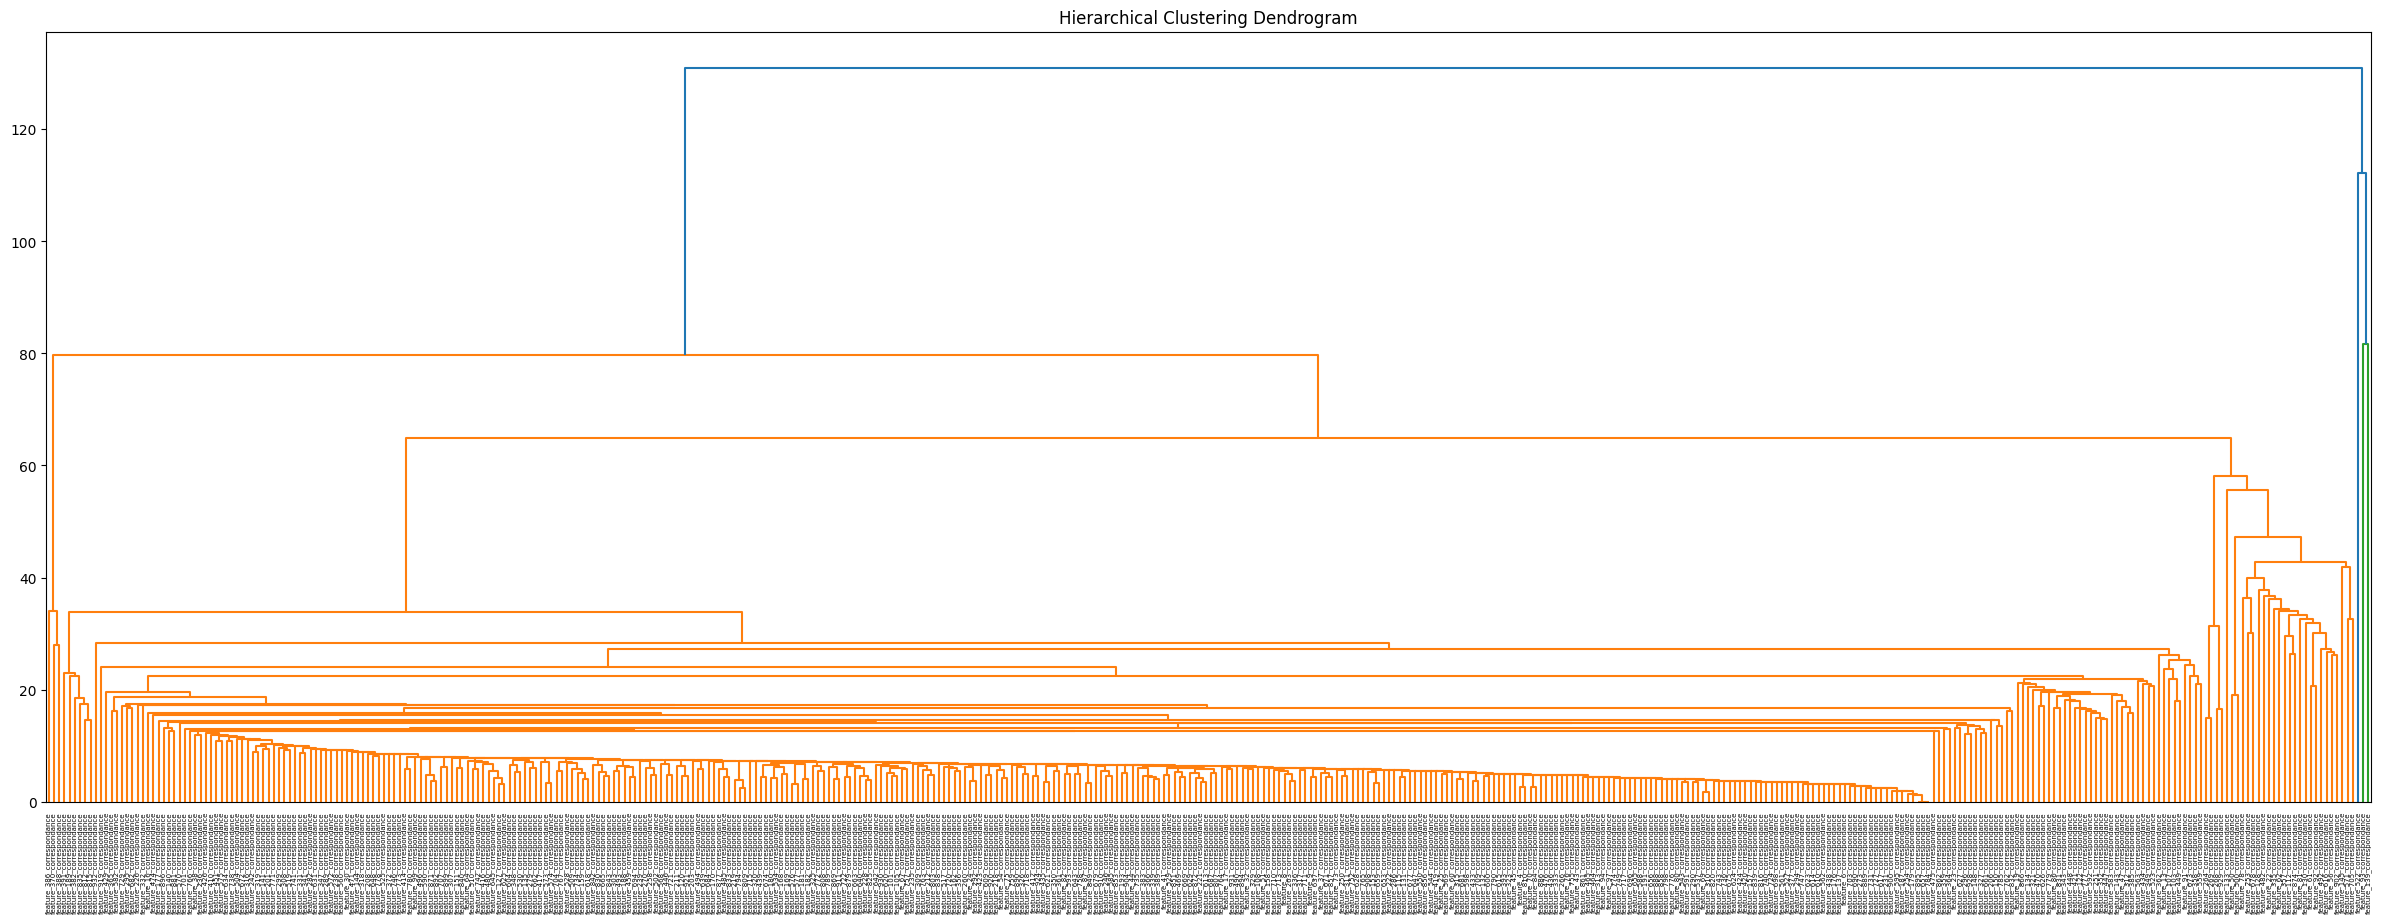

Clusters computed in 0.5238 min
Train shape :  (8398, 185)
Val shape :  (2098, 185)
Test shape :  (3498, 184)


In [11]:
#Clustering of keywords

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def merge_embeddings(df_,keywords_labels, columns_to_cluster, new_suffix="", max_size=100, do_all = False):
    """takes the means of keywords labels of which counts and between 1 and max size"""
    df = df_.copy()
    unique_labels_, counts = np.unique(keywords_labels, return_counts=True)
    unique_labels = unique_labels_[np.logical_and(counts < max_size, counts > 1)] #clusters to keep
    left_out = unique_labels_[np.logical_or(counts >= max_size, counts <= 1)] #clusters to remove except if do all
    for k,label in enumerate(unique_labels):
        key_words_index = np.where(keywords_labels == label)[0]
        current_cluster_columns = [columns_to_cluster[i] for i in key_words_index]
        df[f"cluster_keywords_{k}{new_suffix}"] = df[current_cluster_columns].mean(axis=1)
        df = df.drop(columns=current_cluster_columns)
    if do_all:
      for k,label in enumerate(left_out):
          key_words_index = np.where(keywords_labels == label)[0]
          current_cluster_columns = [columns_to_cluster[i] for i in key_words_index]
          df[f"cluster_keywords_{k}{new_suffix}"] = df[current_cluster_columns].mean(axis=1)
          df = df.drop(columns=current_cluster_columns)
    return df

def compute_keywords_clusters(df_, columns_to_cluster, n_clusters=100, plot=False):
    """computes clustering of keywords in columns"""
    df = df_.copy()
    keywords_features = df[columns_to_cluster].transpose()

    # Clustering
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        compute_distances=True,
        compute_full_tree=True,
    ).fit(keywords_features)

    if plot:
        print("")
        print("Counts : ",np.unique(clustering.labels_, return_counts=True)[1])

        # Plot dendrogram
        plt.figure(figsize=(30, 10))
        plt.title("Hierarchical Clustering Dendrogram")
        plot_dendrogram(clustering, labels=keywords_features.index)
        plt.show()

    return clustering.labels_


def plot_dendrogram(model, **kwargs):
    """Creates linkage matrix and then plots the dendrogram"""
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


t1 = perf_counter()

columns_to_cluster = [f"feature_{i}_correspondance" for i in range(1, 933)]
clusters_to_make = 250
labels = compute_keywords_clusters(train_features, columns_to_cluster, n_clusters=clusters_to_make) #computes clusters on keywords correspondance

train_features = merge_embeddings(train_features, labels, columns_to_cluster)
val_features = merge_embeddings(val_features, labels, columns_to_cluster)
test_features = merge_embeddings(test_features, labels, columns_to_cluster)

columns_to_cluster = [col for col in train_features.columns if "_correspondance" in col]
columns_left = len(columns_to_cluster)
clusters_to_make = 250
print(f"After initial clusterting, columns to cluster : {columns_left}, will attempt {clusters_to_make} new clusters")

i = 0
while clusters_to_make > 50:
  i +=1
  labels = compute_keywords_clusters(train_features,columns_to_cluster, n_clusters=clusters_to_make,plot=False)
  train_features = merge_embeddings(train_features, labels, columns_to_cluster, new_suffix=f"_{i}")
  val_features = merge_embeddings(val_features, labels, columns_to_cluster, new_suffix=f"_{i}")
  test_features = merge_embeddings(test_features, labels, columns_to_cluster, new_suffix=f"_{i}")
  columns_to_cluster = [col for col in train_features.columns if "_correspondance" in col]
  columns_left = len(columns_to_cluster)
  clusters_to_make -= 50
  print(f"After iteration {i}, columns left to cluster : {columns_left}, will attempt {clusters_to_make} new clusters")

labels = compute_keywords_clusters(train_features,columns_to_cluster, n_clusters= clusters_to_make,plot=True)
train_features = merge_embeddings(train_features, labels, columns_to_cluster, new_suffix=f"_{i}", do_all=True)
val_features = merge_embeddings(val_features, labels, columns_to_cluster, new_suffix=f"_{i}", do_all=True)
test_features = merge_embeddings(test_features, labels, columns_to_cluster, new_suffix=f"_{i}", do_all=True)

t2 = perf_counter()
print(f"Clusters computed in {round((t2-t1)/60,4)} min")
print("Train shape : ",train_features.shape)
print("Val shape : ",val_features.shape)
print("Test shape : ",test_features.shape)

In [12]:
# As said before we remove the self loops
# Warning: we need to add them back at the end in the submission
G.remove_edges_from(nx.selfloop_edges(G))

train_features = train_features[train_features["source_node"] != train_features["target_node"]].reset_index(drop=True)
val_features = val_features[val_features["source_node"] != val_features["target_node"]].reset_index(drop=True)
test_features = test_features[test_features["source_node"] != test_features["target_node"]].reset_index(drop=True)

print("Train shape : ",train_features.shape)
print("Val shape : ",val_features.shape)
print("Test shape : ",test_features.shape)

Train shape :  (8380, 185)
Val shape :  (2085, 185)
Test shape :  (3481, 184)


In [13]:
#Node2vec

t1 = perf_counter()

node2vec_dim = 32
node2vec = Node2Vec(G, dimensions=node2vec_dim, walk_length=50, num_walks=40, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = model.wv

def node2vec_similarity(node_pair):
    # Get the embeddings for the node pair
    vector1 = embeddings[str(node_pair[0])]
    vector2 = embeddings[str(node_pair[1])]
    # Calculate cosine similarity (or any other similarity metric)
    similarity = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    return similarity

# Calculate Node2Vec similarity for each node pair in train and test sets
train_features["node2vec_similarity"] = train_features.apply(
    lambda row: node2vec_similarity((int(row["source_node"]), int(row["target_node"]))),axis=1)
val_features["node2vec_similarity"] = val_features.apply(
    lambda row: node2vec_similarity((int(row["source_node"]), int(row["target_node"]))),axis=1)
test_features["node2vec_similarity"] = test_features.apply(
    lambda row: node2vec_similarity((int(row["source_node"]), int(row["target_node"]))),axis=1)

t2 = perf_counter()
print(f"Node2vec computed in {round((t2-t1)/60,4)} min")

print("Train shape : ",train_features.shape)
print("Val shape : ",val_features.shape)
print("Test shape : ",test_features.shape)

Computing transition probabilities:   0%|          | 0/3597 [00:00<?, ?it/s]

Node2vec computed in 7.8933 min
Train shape :  (8380, 186)
Val shape :  (2085, 186)
Test shape :  (3481, 185)


In [14]:
#VGAE

do_VGAE = False

#necessite
if do_VGAE:

  import torch_geometric as tg
  device = "cuda" if torch.cuda.is_available() else "cpu"
  graph_data = tg.utils.from_networkx(G, group_node_attrs="all").to(device)
  val_split = 0.2
  embedding_dim = 2
  epochs = 300
  from torch_geometric.transforms import RandomLinkSplit
  train_data, val_data, _ = RandomLinkSplit(is_undirected=True, num_val=val_split, num_test=0, split_labels=True, add_negative_train_samples=True)(graph_data.clone())

  # Fit vgae
  from torch_geometric.nn.models import VGAE
  from torch_geometric.nn import GCNConv
  from torch_geometric.nn.models import InnerProductDecoder


  class VariationalGCNEncoder(torch.nn.Module):
      def __init__(self, in_channels, out_channels):
          super(VariationalGCNEncoder, self).__init__()
          self.conv1 = GCNConv(
              in_channels, 2 * out_channels)
          self.conv_mu = GCNConv(2 * out_channels, out_channels)
          self.conv_logstd = GCNConv(2 * out_channels, out_channels)

      def forward(self, x, edge_index):
          x = self.conv1(x, edge_index).relu()
          return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


  vgae = VGAE(encoder=VariationalGCNEncoder(932, embedding_dim), decoder=InnerProductDecoder()).to(device)

  train_edge_index = train_data.edge_index.to(device)
  train_pos_edge_index = train_data.pos_edge_label_index.to(device)
  train_neg_edge_index = train_data.neg_edge_label_index.to(device)
  optimizer = torch.optim.Adam(vgae.parameters(), lr=0.01)
  x = train_data.x.to(device)


  def test(pos_edge_index, neg_edge_index):
      vgae.eval()
      with torch.no_grad():
          z = vgae.encode(x, train_pos_edge_index)
      return vgae.test(z, pos_edge_index, neg_edge_index)

  def classify(pos_edge_index, neg_edge_index):
      vgae.eval()
      with torch.no_grad():
          z_neg = vgae.encode(x, neg_edge_index)
          z_pos = vgae.encode(x, pos_edge_index)
      score_neg = ((vgae.decoder(z_neg, neg_edge_index)) < 0.5).sum() / neg_edge_index.size(1)
      score_pos = ((vgae.decoder(z_pos, pos_edge_index)) >= 0.5).sum() / pos_edge_index.size(1)
      print(f"Classification neg accuracy: {score_neg}")
      print(f"Classification pos accuracy: {score_pos}")


  for epoch in range(1, epochs + 1):
      loss = train()
      auc, ap = test(val_data.pos_edge_label_index, val_data.neg_edge_label_index)
      print("Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}".format(epoch, auc, ap))

  classify(val_data.pos_edge_label_index, val_data.neg_edge_label_index)

In [15]:
# Add coefficient standard to networkx

coefficient_function = {
    "preferential_attachment": nx.preferential_attachment,
    "common_neighbors": partial(nx.common_neighbor_centrality, **{"alpha": 1}),
    "jaccard_coefficient": nx.jaccard_coefficient,
    "adamic_adar": nx.adamic_adar_index,
}


for coeff_name, coeff_function in coefficient_function.items():
  train_features[coeff_name] = [coeff for _, _, coeff in coeff_function(G, ebunch=train_features[["source_node", "target_node"]].values)]
  val_features[coeff_name] = [coeff for _, _, coeff in coeff_function(G, ebunch=val_features[["source_node", "target_node"]].values)]
  test_features[coeff_name] = [coeff for _, _, coeff in coeff_function(G, ebunch=test_features[["source_node", "target_node"]].values)]

print("Train shape : ",train_features.shape)
print("Val shape : ",val_features.shape)
print("Test shape : ",test_features.shape)

Train shape :  (8380, 190)
Val shape :  (2085, 190)
Test shape :  (3481, 189)


In [16]:
# Add information from nodes:
degree_dict = nx.degree_centrality(G)

def add_centrality(df_):
  df = df_.copy()
  df["degree_centrality_source"] = [degree_dict[node] for node in df["source_node"]]
  df["degree_centrality_target"] = [degree_dict[node] for node in df["target_node"]]
  df["degree_centrality_max"] = df[["degree_centrality_source","degree_centrality_target"]].max(axis=1)
  df["degree_centrality_min"] = df[["degree_centrality_source","degree_centrality_target"]].min(axis=1)
  df = df.drop(columns=["degree_centrality_target","degree_centrality_source"])
  return df

train_features = add_centrality(train_features)
val_features = add_centrality(val_features)
test_features = add_centrality(test_features)

print("Train shape : ",train_features.shape)
print("Val shape : ",val_features.shape)
print("Test shape : ",test_features.shape)

Train shape :  (8380, 192)
Val shape :  (2085, 192)
Test shape :  (3481, 191)


In [17]:
# Add information from edges:

t1 = perf_counter()

betweeness_dict = nx.edge_betweenness_centrality(G)
used_edge_list = list(betweeness_dict.keys())

shortest_path_dict = nx.shortest_path(G)


def add_edge_info(df):
  for i,(source_node, target_node) in enumerate(df[["source_node","target_node"]].values):
    if (source_node,target_node) in used_edge_list:
      df.loc[i,"edge_betweenness_centrality"] = betweeness_dict[(source_node,target_node)]
    else:
      df.loc[i,"edge_betweenness_centrality"] = 0
    df.loc[i,"shortest_path_length"] = len(shortest_path_dict[source_node][target_node])
  return df

train_features = add_edge_info(train_features)
val_features = add_edge_info(val_features)
test_features = add_edge_info(test_features)

t2 = perf_counter()
print(f"Edge information computed in {round((t2-t1)/60,4)} min")

print("Train shape : ",train_features.shape)
print("Val shape : ",val_features.shape)
print("Test shape : ",test_features.shape)

Edge information computed in 3.0038 min
Train shape :  (8380, 194)
Val shape :  (2085, 194)
Test shape :  (3481, 193)


In [18]:
# Add features from algorithms
t1 = perf_counter()

algorithms_dict = {
    "pagerank": nx.pagerank(G, alpha=0.85, max_iter=1000),
    "katz_centrality": nx.katz_centrality(G, alpha=0.01),
    "clustering_coefficient": nx.clustering(G),
}


def add_alg_info(df):
  for algo_name, algo_dict in algorithms_dict.items():
    df[algo_name+"_max"] = [max(algo_dict[source_node], algo_dict[target_node]) for source_node, target_node in zip(df["source_node"].values, df["target_node"].values)]
    df[algo_name+"_min"] = [min(algo_dict[source_node], algo_dict[target_node]) for source_node, target_node in zip(df["source_node"].values, df["target_node"].values)]
  return df

train_features = add_alg_info(train_features)
val_features = add_alg_info(val_features)
test_features = add_alg_info(test_features)

t2 = perf_counter()
print(f"Algorithms information computed in {round((t2-t1)/60,4)} min")

print("Train shape : ",train_features.shape)
print("Val shape : ",val_features.shape)
print("Test shape : ",test_features.shape)

Algorithms information computed in 0.0121 min
Train shape :  (8380, 200)
Val shape :  (2085, 200)
Test shape :  (3481, 199)


In [19]:
do_tsne = True

if do_tsne:
  from sklearn.manifold import TSNE

  n_components = 3
  tsne = TSNE(n_components=n_components, perplexity=30, n_iter=1000, verbose=1)

  transformed_embedding = tsne.fit_transform(node_info.drop(columns=["node_id"]).values)
  id_to_embedding = {
      node_id: embedding
      for node_id, embedding in zip(node_info["node_id"], transformed_embedding)
  }

  def add_tsne(df):
    for node in ["source_node", "target_node"]:
        for i in range(n_components):
            df[f"tsne_embedding_{node}_{i}"] = [id_to_embedding[node][i] for node in df[node].values]
    return df


  train_features = add_tsne(train_features)
  val_features = add_tsne(val_features)
  test_features = add_tsne(test_features)

  t2 = perf_counter()
  print(f"TSNE information computed in {round((t2-t1)/60,4)} min")

  print("Train shape : ",train_features.shape)
  print("Val shape : ",val_features.shape)
  print("Test shape : ",test_features.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3597 samples in 0.041s...
[t-SNE] Computed neighbors for 3597 samples in 1.631s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3597
[t-SNE] Computed conditional probabilities for sample 2000 / 3597
[t-SNE] Computed conditional probabilities for sample 3000 / 3597
[t-SNE] Computed conditional probabilities for sample 3597 / 3597
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.366196
[t-SNE] KL divergence after 1000 iterations: 1.299733
TSNE information computed in 2.0945 min
Train shape :  (8380, 206)
Val shape :  (2085, 206)
Test shape :  (3481, 205)


## Training

In [22]:
def get_features_cols(train_features,cols_to_remove=None):
  """returns columns to use a final features for model"""
  train_columns = list(train_features.columns)
  train_columns.remove("label")
  train_columns.remove("source_node")
  train_columns.remove("target_node")
  if cols_to_remove:
    for col in cols_to_remove:
      train_columns.remove(col)
  return train_columns

### Random Forest

In [31]:
columns = get_features_cols(train_features)

# Split training data into training and validation sets
train_x, val_x = train_features[columns], val_features[columns]
train_y, val_y = train_features["label"], val_features["label"]

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(train_x, train_y)

# Validate the model
train_pred = clf.predict(train_x)
val_pred = clf.predict(val_x)
val_accuracy = accuracy_score(val_y, val_pred)
train_accuracy = accuracy_score(train_y, train_pred)
print(f"Train accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

Train accuracy: 1.0, Validation Accuracy: 0.5098321342925659


In [38]:
cols_to_remove = ["shortest_path_length","node2vec_similarity","edge_betweenness_centrality"]

columns = get_features_cols(train_features,cols_to_remove=cols_to_remove)

# Split training data into training and validation sets
train_x, val_x = train_features[columns], val_features[columns]
train_y, val_y = train_features["label"], val_features["label"]

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(train_x, train_y)

# Validate the model
train_pred = clf.predict(train_x)
val_pred = clf.predict(val_x)
val_accuracy = accuracy_score(val_y, val_pred)
train_accuracy = accuracy_score(train_y, train_pred)
print(f"Train accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

Train accuracy: 1.0, Validation Accuracy: 0.7453237410071942


In [39]:
cols_to_remove = ["shortest_path_length","node2vec_similarity"]

columns = get_features_cols(train_features,cols_to_remove=cols_to_remove)

# Split training data into training and validation sets
train_x, val_x = train_features[columns], val_features[columns]
train_y, val_y = train_features["label"], val_features["label"]

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(train_x, train_y)

# Validate the model
train_pred = clf.predict(train_x)
val_pred = clf.predict(val_x)
val_accuracy = accuracy_score(val_y, val_pred)
train_accuracy = accuracy_score(train_y, train_pred)
print(f"Train accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

Train accuracy: 1.0, Validation Accuracy: 0.739568345323741


### XGBoost

In [32]:
train_x, val_x = train_features[columns], val_features[columns]
train_y, val_y = train_features["label"], val_features["label"]

model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.01,
    objective="binary:logistic",
    max_depth=6,
    eval_metric="logloss",
    subsample=0.6,
    colsample_bytree=0.8,
    reg_lambda=200,
)

# Fit the model on the training data
model.fit(train_x, train_y)

# Make predictions on the test data
train_pred = model.predict(train_x)
train_accuracy = accuracy_score(train_y, train_pred)

# Evaluate the model
if len(val_features) > 0:
    val_pred = model.predict(val_x)
    val_accuracy = accuracy_score(val_y, val_pred)
else:
    val_accuracy = "No validation data"
print(f"Train accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, columns: {columns}")

Train accuracy: 1.0, Validation Accuracy: 0.5031175059952039, columns: ['cosine_similarity', 'euclidean_distance', 'nb_common_words', 'jaccard_similarity', 'num_words_max', 'num_words_min', 'mean_keyword_values_max', 'mean_keyword_values_min', 'cluster_keywords_0', 'cluster_keywords_1', 'cluster_keywords_2', 'cluster_keywords_3', 'cluster_keywords_4', 'cluster_keywords_5', 'cluster_keywords_6', 'cluster_keywords_7', 'cluster_keywords_8', 'cluster_keywords_9', 'cluster_keywords_10', 'cluster_keywords_11', 'cluster_keywords_12', 'cluster_keywords_13', 'cluster_keywords_14', 'cluster_keywords_15', 'cluster_keywords_16', 'cluster_keywords_17', 'cluster_keywords_18', 'cluster_keywords_19', 'cluster_keywords_20', 'cluster_keywords_21', 'cluster_keywords_22', 'cluster_keywords_23', 'cluster_keywords_24', 'cluster_keywords_25', 'cluster_keywords_26', 'cluster_keywords_27', 'cluster_keywords_28', 'cluster_keywords_29', 'cluster_keywords_30', 'cluster_keywords_31', 'cluster_keywords_32', 'cluste

### Best columns for XGBoost

In [33]:
def generate_combinations(lst):
    all_combinations = []
    for r in range(1, len(lst) + 1):
        all_combinations.extend(itertools.combinations(lst, r))
    return all_combinations

In [34]:
do_combinations = False

#mdr bande de fous
if do_combinations:

  best_columns = None
  best_val_accuracy = 0
  all_columns_combinations = generate_combinations(columns)
  pbar = tqdm(all_columns_combinations)
  for columns in tqdm(pbar):
      columns = list(columns)
      # Split training data into training and validation sets
      train_x, val_x = train_features[columns], val_features[columns]
      train_y, val_y = train_features["label"], val_features["label"]

      model = XGBClassifier(
          n_estimators=400,
          learning_rate=0.01,
          objective="binary:logistic",
          max_depth=6,
          eval_metric="logloss",
          subsample=0.6,
          colsample_bytree=0.8,
          reg_lambda=200,
      )

      # Fit the model on the training data
      model.fit(train_x, train_y)

      # Make predictions on the test data
      val_pred = model.predict(val_x)
      train_pred = model.predict(train_x)

      # Evaluate the model
      val_accuracy = accuracy_score(val_y, val_pred)
      train_accuracy = accuracy_score(train_y, train_pred)
      pbar.set_description(
          f"Train accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, columns: {columns}"
      )
      if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          best_train_accuracy = train_accuracy
          best_columns = columns
  print(f"Best Train accuracy: {best_train_accuracy}, Best Validation Accuracy: {best_val_accuracy}, columns: {best_columns}")

In [36]:
importances = model.feature_importances_

# To make them more readable, zip them with column names into a dictionary
feature_importances = dict(zip(train_x.columns, importances))

# Sort the features by importance
sorted_feature_importances = sorted(
    feature_importances.items(), key=lambda x: x[1], reverse=True
)

for feature, importance in sorted_feature_importances[:10]:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: shortest_path_length, Importance: 0.5069069266319275
Feature: node2vec_similarity, Importance: 0.30835431814193726
Feature: edge_betweenness_centrality, Importance: 0.12641339004039764
Feature: pagerank_max, Importance: 0.01984211802482605
Feature: preferential_attachment, Importance: 0.01167355664074421
Feature: degree_centrality_max, Importance: 0.006623906083405018
Feature: degree_centrality_min, Importance: 0.005680940579622984
Feature: katz_centrality_min, Importance: 0.0022812618408352137
Feature: adamic_adar, Importance: 0.0015501389279961586
Feature: cluster_keywords_28, Importance: 0.0011270246468484402


### Gridsearch XGBoost

In [23]:
from sklearn.model_selection import GridSearchCV

def xgb_grid_search(param_grid,train_x,train_y,val_x,val_y):
  """returns accuracies of best xgb with grid search"""
  xgb_classifier = XGBClassifier()
  grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy',verbose=1)
  grid_search.fit(train_x, train_y)

  print("Best Parameters:", grid_search.best_params_)

  best_xgb_classifier = grid_search.best_estimator_
  train_accuracy = best_xgb_classifier.score(train_x, train_y)
  val_accuracy = best_xgb_classifier.score(val_x, val_y)
  print("Accuracy on train set:", train_accuracy)
  print("Accuracy on val set:", val_accuracy)
  return best_xgb_classifier


def xgb_importance(model,train_x,plot_max=5):
  """prints most 5 important features of model"""
  importances = model.feature_importances_
  feature_importances = dict(zip(train_x.columns, importances))
  sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
  if plot_max=="plot_all":
    for feature, importance in sorted_feature_importances:
        print(f"Feature: {feature}, Importance: {importance}")
  else:
    for feature, importance in sorted_feature_importances[0:5]:
        print(f"Feature: {feature}, Importance: {importance}")

def xgb_pipeline(train_features,param_grid,cols_to_remove=None,):
  train_columns = get_features_cols(train_features,cols_to_remove=cols_to_remove)
  train_x, val_x = train_features[train_columns], val_features[train_columns]
  train_y, val_y = train_features["label"], val_features["label"]

  best_xgb_classifier = xgb_grid_search(param_grid,train_x,train_y,val_x,val_y)
  xgb_importance(best_xgb_classifier,train_x)

In [38]:
param_grid = {
    'n_estimators': [50,100,400],
    'objective' : ["binary:logistic"],
    'max_depth': [6,10],
    'learning_rate': [0.01,0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma':[0,0.1],
    'eval_metric' : ["logloss"],
    'reg_lambda': [1,10,200],
}

xgb_pipeline(train_features,param_grid)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Parameters: {'colsample_bytree': 0.6, 'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50, 'objective': 'binary:logistic', 'reg_lambda': 1, 'subsample': 0.6}
Accuracy on train set: 1.0
Accuracy on val set: 0.5031175059952039
Feature: shortest_path_length, Importance: 0.5094127655029297
Feature: node2vec_similarity, Importance: 0.2427002191543579
Feature: edge_betweenness_centrality, Importance: 0.17632955312728882
Feature: preferential_attachment, Importance: 0.015941275283694267
Feature: pagerank_max, Importance: 0.014850273728370667


In [24]:
param_grid = {
    'n_estimators': [30,50,100],
    'objective' : ["binary:logistic"],
    'max_depth': [3,6,10],
    'learning_rate': [0.001,0.01],
    'subsample': [0.6],
    'colsample_bytree': [0.6],
    'gamma':[0],
    'eval_metric' : ["logloss"],
    'reg_lambda': [0.1,1],
}

xgb_pipeline(train_features,param_grid,cols_to_remove=["shortest_path_length"])

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'colsample_bytree': 0.6, 'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'objective': 'binary:logistic', 'reg_lambda': 0.1, 'subsample': 0.6}
Accuracy on train set: 0.9992840095465394
Accuracy on val set: 0.5702637889688249
Feature: node2vec_similarity, Importance: 0.4510824382305145
Feature: edge_betweenness_centrality, Importance: 0.27138271927833557
Feature: pagerank_max, Importance: 0.04957805201411247
Feature: degree_centrality_max, Importance: 0.024955466389656067
Feature: preferential_attachment, Importance: 0.01965157873928547


In [31]:
param_grid = {
    'n_estimators': [30,50,100],
    'objective' : ["binary:logistic"],
    'max_depth': [10,20,30],
    'learning_rate': [0.01,0.05],
    'subsample': [0.6],
    'colsample_bytree': [0.6],
    'gamma':[0],
    'eval_metric' : ["logloss"],
    'reg_lambda': [1],
}


xgb_pipeline(train_features,param_grid,cols_to_remove=["shortest_path_length","node2vec_similarity"])

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'colsample_bytree': 0.6, 'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 50, 'objective': 'binary:logistic', 'reg_lambda': 1, 'subsample': 0.6}
Accuracy on train set: 0.9736276849642005
Accuracy on val set: 0.7223021582733813
Feature: edge_betweenness_centrality, Importance: 0.6809560656547546
Feature: degree_centrality_max, Importance: 0.025220781564712524
Feature: pagerank_max, Importance: 0.02432144619524479
Feature: preferential_attachment, Importance: 0.022338829934597015
Feature: katz_centrality_min, Importance: 0.01021931879222393


In [32]:
param_grid = {
    'n_estimators': [20,30,50],
    'objective' : ["binary:logistic"],
    'max_depth': [10,20,30],
    'learning_rate': [0.05],
    'subsample': [0.6],
    'colsample_bytree': [0.6],
    'gamma':[0],
    'eval_metric' : ["logloss"],
    'reg_lambda': [1],
}


xgb_pipeline(train_features,param_grid,cols_to_remove=["shortest_path_length","node2vec_similarity","edge_betweenness_centrality"])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'colsample_bytree': 0.6, 'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 30, 'objective': 'binary:logistic', 'reg_lambda': 1, 'subsample': 0.6}
Accuracy on train set: 0.9713603818615751
Accuracy on val set: 0.728537170263789
Feature: preferential_attachment, Importance: 0.09978783875703812
Feature: pagerank_max, Importance: 0.06362153589725494
Feature: katz_centrality_min, Importance: 0.03714245185256004
Feature: degree_centrality_max, Importance: 0.032542433589696884
Feature: degree_centrality_min, Importance: 0.022479195147752762


## Build submission

In [44]:
def make_final_model(cols_to_remove, params, importance=True, xgb=True):
  X_test = test_features[get_features_cols(train_features,cols_to_remove=cols_to_remove)]
  X_train = train_features[get_features_cols(train_features,cols_to_remove=cols_to_remove)]
  y_train = train_features["label"]

  if xgb:
    model = XGBClassifier(**params)
  else:
    model = RandomForestClassifier(n_estimators=1000)

  model.fit(X_train,y_train)

  if importance:
    xgb_importance(model,X_train,plot_max=10)

  test_predictions = model.predict(X_test)
  predictions_dict = {(test_features.iloc[i]["source_node"],test_features.iloc[i]["target_node"]):prediction for i,prediction in enumerate(test_predictions)}

  return predictions_dict


cols_to_remove = ["shortest_path_length","node2vec_similarity","edge_betweenness_centrality"]

columns = get_features_cols(train_features,cols_to_remove=cols_to_remove)


def get_submissions(df_,predictions_dict):
  df = df_.copy()
  df = df.reset_index(drop=True)

  self_loops = np.where(df["source_node"] == df["target_node"])[0]
  submissions = []
  for i in df.index:
    if i in self_loops:
      submissions.append(1)
    else:
      submissions.append(predictions_dict[(df.iloc[i]["source_node"],df.iloc[i]["target_node"])])
  return submissions


In [37]:
cols_to_remove = ["shortest_path_length","node2vec_similarity"]
params = {'colsample_bytree': 0.6, 'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 50, 'objective': 'binary:logistic', 'reg_lambda': 1, 'subsample': 0.6}

predictions_dict = make_final_model(cols_to_remove, params)
submission_df = pd.DataFrame({"ID":range(len(test_data)),"Predicted":get_submissions(test_data,predictions_dict)})
print("Sumissions shape : ",submission_df.shape)
submission_df.to_csv("submission.csv", index=False)

Feature: edge_betweenness_centrality, Importance: 0.6809560656547546
Feature: degree_centrality_max, Importance: 0.025220781564712524
Feature: pagerank_max, Importance: 0.02432144619524479
Feature: preferential_attachment, Importance: 0.022338829934597015
Feature: katz_centrality_min, Importance: 0.01021931879222393
Sumissions shape :  (3498, 2)


In [36]:
cols_to_remove = ["shortest_path_length","node2vec_similarity","edge_betweenness_centrality"]
params = {'colsample_bytree': 0.6, 'eval_metric': 'logloss', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 30, 'objective': 'binary:logistic', 'reg_lambda': 1, 'subsample': 0.6}

predictions_dict = make_final_model(cols_to_remove, params)
submission_df = pd.DataFrame({"ID":range(len(test_data)),"Predicted":get_submissions(test_data,predictions_dict)})
print("Sumissions shape : ",submission_df.shape)
submission_df.to_csv("submission2.csv", index=False)

Feature: preferential_attachment, Importance: 0.09978783875703812
Feature: pagerank_max, Importance: 0.06362153589725494
Feature: katz_centrality_min, Importance: 0.03714245185256004
Feature: degree_centrality_max, Importance: 0.032542433589696884
Feature: degree_centrality_min, Importance: 0.022479195147752762
Sumissions shape :  (3498, 2)


In [43]:
cols_to_remove = ["shortest_path_length","node2vec_similarity",]
params = None

predictions_dict = make_final_model(cols_to_remove, params, xgb=False)
submission_df = pd.DataFrame({"ID":range(len(test_data)),"Predicted":get_submissions(test_data,predictions_dict)})
print("Sumissions shape : ",submission_df.shape)
submission_df.to_csv("submission3.csv", index=False)

Feature: edge_betweenness_centrality, Importance: 0.19252623322594364
Feature: pagerank_max, Importance: 0.09343904397367456
Feature: katz_centrality_min, Importance: 0.07785389755790846
Feature: preferential_attachment, Importance: 0.07207038987201785
Feature: degree_centrality_max, Importance: 0.0653360202654001
Sumissions shape :  (3498, 2)
